# Simulation 0

In [191]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import random
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.kernel_ridge import KernelRidge
import seaborn as sns

import torch
from torch.utils.data import Dataset,DataLoader
from torch import optim
import torch.nn as nn
import torch.nn.utils.prune as prune
import torch.nn.functional as F

## Random Feature

In [192]:
def sample_1d(pdf, gamma):
    if pdf=='G':
        w=torch.randn(1)*gamma
        return w
    elif pdf=='L':
        w=torch.distributions.laplace.Laplace(torch.tensor([0.0]), torch.tensor([1.0])).sample()*gamma
        return w
    elif pdf=='C':
        w=torch.distributions.cauchy.Cauchy(torch.tensor([0.0]), torch.tensor([1.0])).sample()*gamma
        return w
    
def sample(pdf, gamma, d):
    return torch.tensor([sample_1d(pdf, gamma) for _ in range(d)])

class RandomFourierFeature:
    """Random Fourier Feature
    Parameters
    ----------
    d : int
        Input space dimension
    D : int
        Feature space dimension
    W : shape (D,d)
    b : shape (D)
    kernel : char
        Kernel to use; 'G', 'L', or 'C'
    gamma : float
        pdf parameter
    """

    def __init__(self, d, D, W=None, b=None, kernel='G', gamma=1):

        self.d = d
        self.D = D
        self.gamma = gamma

        kernel = kernel.upper()
        if kernel not in ['G', 'L', 'C']:
            raise Exception('Invalid Kernel')
        self.kernel = kernel

        if W is None or b is None:
            self.create()
        else:
            self.__load(W, b)

    def __load(self, W, b):
        """Load from existing Arrays"""

        self.W = W.reshape([self.D, self.d])
        self.b = b
    

    def create(self):
        """Create a d->D fourier random feature"""

        self.b = torch.rand(self.D)*2*torch.pi
        self.W = sample(self.kernel, self.gamma, self.d*self.D).reshape(self.D,self.d)

    def transform(self, x):
        """Transform a vector using this feature
        Parameters
        ----------
        x : (shape=(n,d))
            to transform; must be single dimension vector
        Returns
        -------
        x : (shape=(n,D))
            Feature space transformation of x
        """
       
        result=torch.sqrt(torch.tensor([2.0/self.D])) * torch.cos( self.W @ x.T  + (self.b.reshape(-1,1) @ torch.ones(len(x)).reshape(1,-1))) 
        return result.T

## Problem setup -- 1

data generation

In [193]:
#sin func
def sinfunc(x):
    return np.sin(x*10*np.pi)

np.random.seed(0)
data=np.random.uniform(0,1,(1000,1))
y=sinfunc(data)

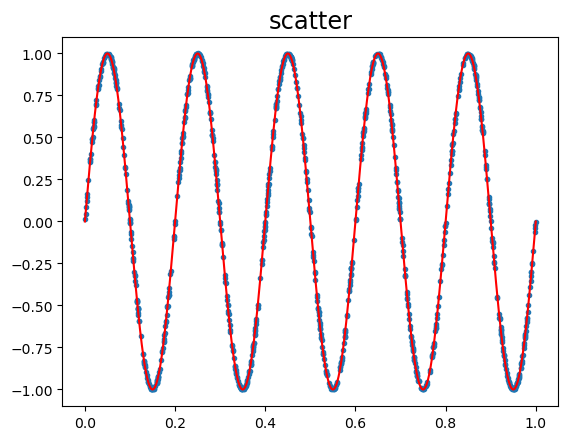

In [194]:
plot_x=np.linspace(0,1,1000)
plt.plot(plot_x,np.sin(plot_x*10*np.pi),color="red")
plt.scatter(data.T[0],y,marker=".")
plt.title("scatter",fontsize="xx-large")
plt.show()

In [195]:
train_x=data
train_y=y
nntrain_x = torch.from_numpy(train_x).float()
nntrain_y = torch.squeeze(torch.from_numpy(train_y).float()) 

class mydataset(Dataset):
    def __init__(self, x, y):
        self._x = x
        self._y = y
        self._len = len(x)

    def __getitem__(self, item): 
        return self._x[item], self._y[item]

    def __len__(self):
        return self._len

## KRR

In [196]:
t0=time.time()
krr = KernelRidge(alpha=1e-3,kernel='rbf',gamma=100)
krr.fit(train_x, train_y)
krr_pred=krr.predict(train_x)
t1=time.time()-t0
print(mean_squared_error(train_y,krr_pred))
print("Time:",t1)

6.875585245035224e-08
Time: 0.05179595947265625


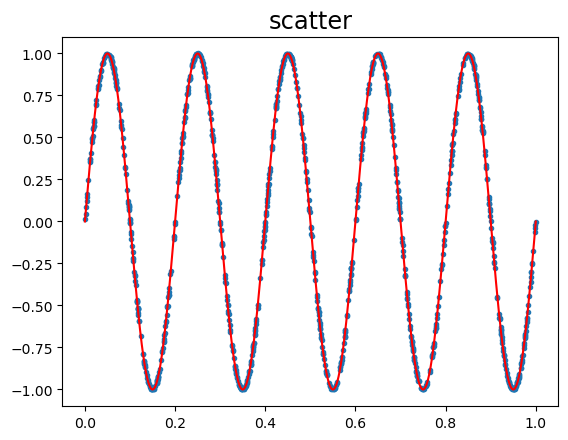

In [197]:
plot_x=np.linspace(0,1,1000)
plt.plot(plot_x,np.sin(plot_x*10*np.pi),color="red")
plt.scatter(data.T[0],krr_pred,marker=".")
plt.title("scatter",fontsize="xx-large")
plt.show()

## RF

In [224]:
t0=time.time()
model=Ridge(alpha=1e-3)
rff=RandomFourierFeature(1,200,kernel='G',gamma=10)
feature=rff.transform(train_x)
model.fit(feature,train_y)
rf_pred=model.predict(feature)
t1=time.time()-t0
print(mean_squared_error(train_y,rf_pred))
print("Time:",t1)

0.007240798087633835
Time: 0.013757467269897461


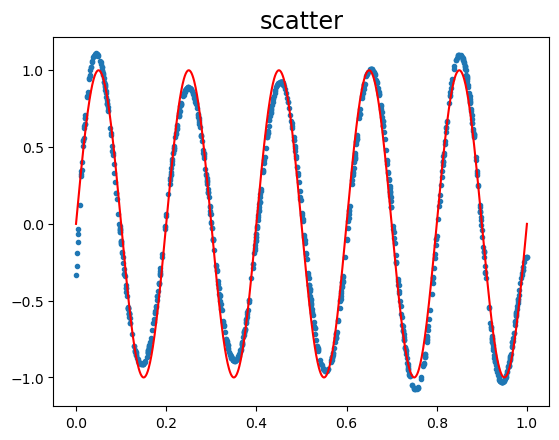

In [225]:
plot_x=np.linspace(0,1,1000)
plt.plot(plot_x,np.sin(plot_x*10*np.pi),color="red")
plt.scatter(data.T[0],rf_pred,marker=".")
plt.title("scatter",fontsize="xx-large")
plt.show()

# MLK

In [200]:
train_loader = DataLoader(mydataset(nntrain_x, nntrain_y),batch_size=128, shuffle=True)

rff1=RandomFourierFeature(1,64,kernel='G',gamma=10)
rff2=RandomFourierFeature(8,8,kernel='G',gamma=10)

class KernelNet(nn.Module): 
    def __init__(self):
        super(KernelNet, self).__init__()
        self.fc1 = nn.Linear(64, 8)
        self.fc2 = nn.Linear(8, 1)
        
    def forward(self, x):
        x = rff1.transform(x)
        x=self.fc1(x)
        x = rff2.transform(x)
        return self.fc2(x)


#initialize
def init_weights(m):
    if type(m) == nn.Conv2d:
        torch.nn.init.normal_(m.weight,mean=0,std=0.5)
    if type(m) == nn.Linear:
        torch.nn.init.uniform_(m.weight,a=-0.5,b=-0.5)
        m.bias.data.fill_(0.01)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = KernelNet()
net = net.to(device)
torch.manual_seed(1)
net.apply(init_weights)
print(net)
criterion=nn.MSELoss() 
optimizer=optim.SGD(net.parameters(),lr=1e-3,momentum=0.9,weight_decay=1e-3) #optim.Adam(...)

loss=[]
kernelnn_trainloss=[]
kernelnn_testloss=[]
t0 = time.time()
for epoch in range(2000): 
    for x, y in train_loader: #for batch, (x, y) in enumerate(train_loader): 
        x, y = x.to(device), y.to(device)
        # Compute prediction error
        y_pred = net(x)
        y_pred = torch.squeeze(y_pred)
        train_loss = criterion(y_pred, y)
        loss.append(train_loss)
        # Backpropagation
        optimizer.zero_grad() 
        train_loss.backward()
        optimizer.step()
    
    x0=torch.from_numpy(train_x[:]).float()
    with torch.no_grad():
        x0 = x0.to(device)
        pred = net(x0)
    
    x0=torch.from_numpy(train_x[:]).float()
    with torch.no_grad():
        x0 = x0.to(device)
        pred = net(x0)
    
    kernelnn_trainloss.append(mean_squared_error(pred,train_y))
    
    if epoch % 100 == 0:        
        print(f'''epoch {epoch}
            Train set - loss: {kernelnn_trainloss[-1]}
            ''')
        
    
dnn_fit = time.time() - t0
print("KernelNet complexity and model fitted in %.3f s" % dnn_fit)

KernelNet(
  (fc1): Linear(in_features=64, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=1, bias=True)
)
epoch 0
            Train set - loss: 0.5387032025394096
            
epoch 100
            Train set - loss: 0.0029781823130849466
            
epoch 200
            Train set - loss: 0.0011547219961172885
            
epoch 300
            Train set - loss: 0.0007330506059704509
            
epoch 400
            Train set - loss: 0.0005330621415872997
            
epoch 500
            Train set - loss: 0.0004085198921920179
            
epoch 600
            Train set - loss: 0.000338514908624943
            
epoch 700
            Train set - loss: 0.0002784741495981805
            
epoch 800
            Train set - loss: 0.0002413200177213702
            
epoch 900
            Train set - loss: 0.00022446850561313515
            
epoch 1000
            Train set - loss: 0.0001947228360411431
            
epoch 1100
            Train set - loss: 0.000176

In [201]:
kernel_x0=torch.from_numpy(train_x[:]).float()
with torch.no_grad():
    kernel_x0 = kernel_x0.to(device)
    kernel_pred = net(kernel_x0)
    print(np.array(kernel_pred).reshape(-1))

[-9.94494140e-01 -4.74221498e-01  9.88352224e-02 -9.83849585e-01
  6.93755627e-01  9.75276232e-01  9.23055291e-01  2.45159268e-01
 -9.02454376e-01 -5.05662322e-01 -2.84566760e-01 -7.89027512e-01
 -8.44361126e-01 -7.12842584e-01  7.88584948e-01  3.97584766e-01
  5.90309083e-01  8.35842788e-01 -6.57884300e-01  8.14079046e-01
 -6.05518281e-01 -4.10911292e-02  9.19708729e-01 -6.02371514e-01
 -5.44826329e-01  9.32204723e-01 -9.78641748e-01 -9.96909440e-01
 -6.32131755e-01  4.64943677e-01  8.85928452e-01 -7.38952398e-01
  9.62369442e-01 -8.38038385e-01  5.53292155e-01  5.37886322e-01
  3.88976276e-01  5.20164907e-01 -9.90936458e-01  5.41244984e-01
 -9.50562954e-01  9.17191505e-01  7.20617324e-02  9.46969867e-01
  8.69394600e-01  8.02064836e-01  3.13671470e-01 -7.93131113e-01
 -4.72458452e-01 -9.03921127e-01 -8.07860792e-01  9.33049142e-01
 -3.57682109e-01 -5.95014840e-02  2.67503649e-01 -9.28868473e-01
  9.90880609e-01  9.89966631e-01  8.61223817e-01  9.88213897e-01
 -9.52504337e-01 -3.18432

### Conformal confidence bands for MLKM

In [202]:
##calibration set
np.random.seed(1)
calibration_x=np.random.uniform(0,1,(1000,1))
calibration_y=sinfunc(calibration_x)

##conformal prediction
#predict

coverage=0
par=optimizer.param_groups[0]['params']
for i in range(len(train_x)):
    x0=torch.from_numpy(train_x[i:1+i]).float()
    x0 = x0.to(device)
    pred = net(x0)
    fi=torch.tensor([])
    for j in range(len(par)):
        par[j].grad.data.zero_()
    pred.backward()   
    for j in range(len(par)): 
        fi=torch.cat([fi,par[j].grad.reshape(-1)])
    fi=fi.reshape(1,-1)
    if i==0:
        Fi=fi
    else:
        Fi=torch.cat([Fi,fi])   
temp=torch.linalg.inv(Fi.T @ Fi)

mark=0
score=torch.tensor([])
for i in tqdm(range(len(train_x))):
    x0=torch.from_numpy(train_x[i:i+1]).float()
    x0 = x0.to(device)
    pred = net(x0)
    par=optimizer.param_groups[0]['params']
    f0=torch.tensor([])
    for j in range(len(par)):
        par[j].grad.data.zero_()
    pred.backward()
    for j in range(len(par)):
        f0=torch.cat([f0,par[j].grad.reshape(-1)])
    f0=f0.reshape(-1,1)
    fFFf=f0.T @ temp @ f0
    if fFFf < 0:
        continue
    score=torch.cat([score,np.abs(pred.detach().numpy()[0][0]-train_y[i])/np.sqrt(kernelnn_trainloss[-1])/np.sqrt(fFFf+1)])
    mark=mark+1
score=score.reshape(-1)
sorted_score, sorted_indices=torch.sort(score)
q=(len(score)+1)*0.95
a=sorted_score[int(np.ceil(q))]



pred_xall=[]
pred_yall=[]
true_yall=[]
dist=[]
mark=0
length=[]
for i in tqdm(range(len(calibration_x))):
    x0=torch.from_numpy(calibration_x[i:i+1]).float()
    x0 = x0.to(device)
    pred = net(x0)
    par=optimizer.param_groups[0]['params']
    f0=torch.tensor([])
    for j in range(len(par)):
        par[j].grad.data.zero_()
    pred.backward()
    for j in range(len(par)):
        f0=torch.cat([f0,par[j].grad.reshape(-1)])
    f0=f0.reshape(-1,1)

    fFFf=f0.T @ temp @ f0
    
    if fFFf < 0:
        continue
    mark=mark+1
    dd=(np.sqrt(kernelnn_trainloss[-1])*np.sqrt(fFFf+1)*a).detach().numpy()[0][0]
    length.append(2*dd)
    
    #coverage
    if pred.detach().numpy()[0][0]-dd<calibration_y[i] and pred.detach().numpy()[0][0]+dd>calibration_y[i]:
        coverage=coverage+1
    pred_xall.append(calibration_x[i][0])
    pred_yall.append(pred.detach().numpy()[0][0])
    true_yall.append(calibration_y[i])
    dist.append(dd)
coverage=coverage/mark


print("length",np.mean(length))
print("95 coverage",coverage)

100%|██████████| 1000/1000 [00:00<00:00, 1836.73it/s]

length 0.07747023172808302
95 coverage 0.9528487229862476


## RK

In [203]:
train_loader = DataLoader(mydataset(nntrain_x, nntrain_y),batch_size=128, shuffle=True)

rff0=RandomFourierFeature(1,64,kernel='G',gamma=10)
rff1=RandomFourierFeature(8,8,kernel='G',gamma=10)

class ResidualBlock(nn.Module):
    def __init__(self,infeatures,outfeatures,rff):
        super(ResidualBlock,self).__init__()
        self.infeatures = infeatures
        self.outfeatures = outfeatures
        self.rff=rff
        
        self.fc1 = nn.Linear(infeatures,outfeatures)
        self.fc2 = nn.Linear(outfeatures,outfeatures)
    
    def forward(self, x):
        rff=self.rff
        x = self.fc1(x)
        y = rff.transform(x)
        y = self.fc2(y)
        return x+y

class ResKernelNet(nn.Module): 
    def __init__(self):
        super(ResKernelNet, self).__init__()
        self.rblock1 = ResidualBlock(64,8,rff1)
        self.fc2 =nn.Linear(8,1)
 
    def forward(self, x):
        x = rff0.transform(x)
        x = self.rblock1(x)
        return self.fc2(x)

#initialize
def init_weights(m):
    if type(m) == nn.Conv2d:
        torch.nn.init.normal_(m.weight,mean=0,std=0.5)
    if type(m) == nn.Linear:
        torch.nn.init.uniform_(m.weight,a=-0.5,b=0.5)
        m.bias.data.fill_(0.01)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = ResKernelNet()
net = net.to(device)
torch.manual_seed(1)
#net.apply(init_weights)
print(net)
criterion=nn.MSELoss() 
optimizer=optim.SGD(net.parameters(),lr=5e-3,momentum=0.9,weight_decay=1e-3) #optim.Adam(...)

loss=[]
reskernel_trainloss=[]
reskernel_testloss=[]
t0 = time.time()
for epoch in range(2000): 
    for x, y in train_loader: #for batch, (x, y) in enumerate(train_loader): 
        x, y = x.to(device), y.to(device)
        # Compute prediction error
        y_pred = net(x)
        y_pred = torch.squeeze(y_pred)
        train_loss = criterion(y_pred, y)
        loss.append(train_loss)
        # Backpropagation
        optimizer.zero_grad() 
        train_loss.backward()
        optimizer.step()
    
    x0=torch.from_numpy(train_x[:]).float()
    with torch.no_grad():
        x0 = x0.to(device)
        pred = net(x0)
    
    reskernel_trainloss.append(mean_squared_error(pred,train_y))
    
    if epoch % 100 == 0:        
        print(f'''epoch {epoch}
            Train set - loss: {reskernel_trainloss[-1]}
            ''')
        
    
dnn_fit = time.time() - t0
print("Residual KernelNet complexity and model fitted in %.3f s" % dnn_fit)

ResKernelNet(
  (rblock1): ResidualBlock(
    (fc1): Linear(in_features=64, out_features=8, bias=True)
    (fc2): Linear(in_features=8, out_features=8, bias=True)
  )
  (fc2): Linear(in_features=8, out_features=1, bias=True)
)
epoch 0
            Train set - loss: 0.3983663110400812
            
epoch 100
            Train set - loss: 7.237725159000088e-05
            
epoch 200
            Train set - loss: 2.8826882610245243e-05
            
epoch 300
            Train set - loss: 1.9729174441351043e-05
            
epoch 400
            Train set - loss: 1.776467820930967e-05
            
epoch 500
            Train set - loss: 1.6005663220221865e-05
            
epoch 600
            Train set - loss: 1.5732246249199713e-05
            
epoch 700
            Train set - loss: 1.6008729302997692e-05
            
epoch 800
            Train set - loss: 1.5313356901077242e-05
            
epoch 900
            Train set - loss: 1.4258393741275198e-05
            
epoch 1000
          

In [204]:
rk_x0=torch.from_numpy(train_x[:]).float()
with torch.no_grad():
    rk_x0 = rk_x0.to(device)
    rk_pred = net(rk_x0)
    print(np.array(rk_pred).reshape(-1))

[-1.00507140e+00 -4.53965336e-01  8.21752548e-02 -9.92767811e-01
  6.76374137e-01  9.92644489e-01  9.27524984e-01  2.53788859e-01
 -9.11039054e-01 -4.91005749e-01 -2.53928512e-01 -7.87141860e-01
 -8.41396511e-01 -7.20361590e-01  7.89934993e-01  3.99910241e-01
  5.94423234e-01  8.58572125e-01 -6.26220465e-01  8.06075633e-01
 -6.20402753e-01 -2.84291189e-02  9.33236361e-01 -5.66832125e-01
 -5.43377936e-01  9.51652884e-01 -9.69466925e-01 -9.86922562e-01
 -6.29655480e-01  4.43061560e-01  8.97711694e-01 -7.17304230e-01
  9.80812907e-01 -8.34584832e-01  5.57191372e-01  5.20939410e-01
  3.64871621e-01  5.01899719e-01 -9.81691003e-01  5.34690261e-01
 -9.58179235e-01  9.20700610e-01  7.63653815e-02  9.45826352e-01
  8.58073950e-01  7.89930880e-01  3.18572015e-01 -7.78827786e-01
 -4.60915238e-01 -9.09028053e-01 -8.02258968e-01  9.39240754e-01
 -3.53531182e-01 -6.56204149e-02  2.74293214e-01 -9.43636775e-01
  9.94066715e-01  9.94058549e-01  8.67711008e-01  9.80366409e-01
 -9.65846837e-01 -3.24423

In [205]:
##calibration set
np.random.seed(1)
calibration_x=np.random.uniform(0,1,(1000,1))
calibration_y=sinfunc(calibration_x)

##conformal prediction
#predict

coverage=0
par=optimizer.param_groups[0]['params']
for i in range(len(train_x)):
    x0=torch.from_numpy(train_x[i:1+i]).float()
    x0 = x0.to(device)
    pred = net(x0)
    fi=torch.tensor([])
    for j in range(len(par)):
        par[j].grad.data.zero_()
    pred.backward()   
    for j in range(len(par)): 
        fi=torch.cat([fi,par[j].grad.reshape(-1)])
    fi=fi.reshape(1,-1)
    if i==0:
        Fi=fi
    else:
        Fi=torch.cat([Fi,fi])   
temp=torch.linalg.inv(Fi.T @ Fi)

mark=0
score=torch.tensor([])
for i in tqdm(range(len(train_x))):
    x0=torch.from_numpy(train_x[i:i+1]).float()
    x0 = x0.to(device)
    pred = net(x0)
    par=optimizer.param_groups[0]['params']
    f0=torch.tensor([])
    for j in range(len(par)):
        par[j].grad.data.zero_()
    pred.backward()
    for j in range(len(par)):
        f0=torch.cat([f0,par[j].grad.reshape(-1)])
    f0=f0.reshape(-1,1)
    fFFf=f0.T @ temp @ f0
    if fFFf < 0:
        continue
    score=torch.cat([score,np.abs(pred.detach().numpy()[0][0]-train_y[i])/np.sqrt(reskernel_trainloss[-1])/np.sqrt(fFFf+1)])
    mark=mark+1
score=score.reshape(-1)
sorted_score, sorted_indices=torch.sort(score)
q=(len(score)+1)*0.95
a=sorted_score[int(np.ceil(q))]



pred_xall2=[]
pred_yall2=[]
true_yall2=[]
dist2=[]
mark=0
length=[]
for i in tqdm(range(len(calibration_x))):
    x0=torch.from_numpy(calibration_x[i:i+1]).float()
    x0 = x0.to(device)
    pred = net(x0)
    par=optimizer.param_groups[0]['params']
    f0=torch.tensor([])
    for j in range(len(par)):
        par[j].grad.data.zero_()
    pred.backward()
    for j in range(len(par)):
        f0=torch.cat([f0,par[j].grad.reshape(-1)])
    f0=f0.reshape(-1,1)

    fFFf=f0.T @ temp @ f0
    
    if fFFf < 0:
        continue
    mark=mark+1
    dd=(np.sqrt(reskernel_trainloss[-1])*np.sqrt(fFFf+1)*a).detach().numpy()[0][0]
    length.append(2*dd)
    
    #coverage
    if pred.detach().numpy()[0][0]-dd<calibration_y[i] and pred.detach().numpy()[0][0]+dd>calibration_y[i]:
        coverage=coverage+1
    pred_xall2.append(calibration_x[i][0])
    pred_yall2.append(pred.detach().numpy()[0][0])
    true_yall2.append(calibration_y[i])
    dist2.append(dd)
coverage=coverage/mark


print("length",np.mean(length))
print("95 coverage",coverage)

100%|██████████| 1000/1000 [00:00<00:00, 1353.93it/s]

length 0.027783806813078318
95 coverage 0.9545454545454546


In [206]:
print(mean_squared_error(kernel_pred,train_y))
print(mean_squared_error(rk_pred,train_y))

0.00011592066716370986
1.7115524283141205e-05


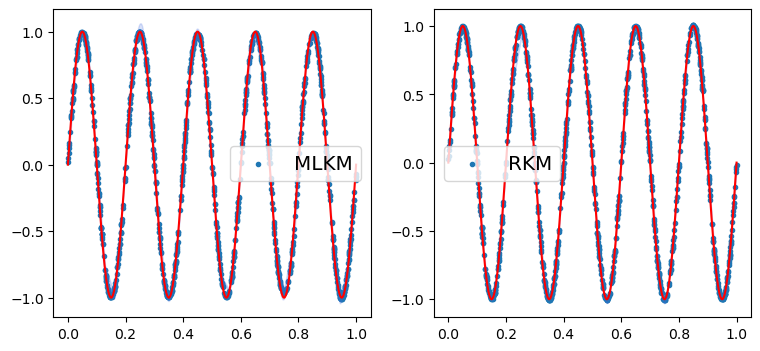

In [226]:
fig,ax=plt.subplots(1,2, figsize=(9, 4))
plot_x=np.linspace(0,1,1000)
#ax[0].scatter(calibration_x,calibration_y,marker=".",color='gray',label='_nolegend_')
ax[0].scatter(data.T[0],kernel_pred,marker=".")
ax[0].plot(plot_x,np.sin(plot_x*10*np.pi),color="red")
ax[0].legend(["MLKM"],fontsize="x-large")
band=np.array([pred_xall,list(map(lambda x,y:x-y, pred_yall,dist)),list(map(lambda x,y:x+y, pred_yall,dist))]).T
sort_band=band[np.argsort(band[:,0])]
plot_x=np.linspace(0,1,1000)
ax[0].fill_between(sort_band.T[0],sort_band.T[1],sort_band.T[2],alpha=0.2,color='royalblue')
#ax[1].scatter(calibration_x,calibration_y,marker=".",color='gray',label='_nolegend_')
ax[1].scatter(data.T[0],rk_pred,marker=".")
ax[1].plot(plot_x,np.sin(plot_x*10*np.pi),color="red")
ax[1].legend(["RKM"],fontsize="x-large")
band=np.array([pred_xall2,list(map(lambda x,y:x-y, pred_yall2,dist2)),list(map(lambda x,y:x+y, pred_yall2,dist2))]).T
sort_band=band[np.argsort(band[:,0])]
plot_x=np.linspace(0,1,1000)
ax[1].fill_between(sort_band.T[0],sort_band.T[1],sort_band.T[2],alpha=0.2,color='royalblue')
plt.show()

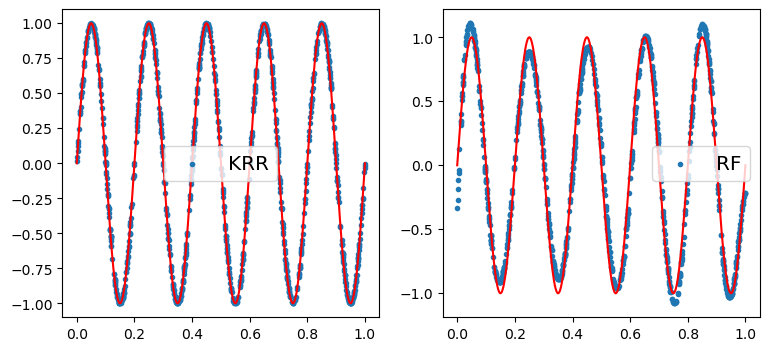

In [227]:
fig,ax=plt.subplots(1,2, figsize=(9, 4))
plot_x=np.linspace(0,1,1000)
#ax[0].scatter(calibration_x,calibration_y,marker=".",color='gray',label='_nolegend_')
ax[0].scatter(data.T[0],krr_pred,marker=".")
ax[0].plot(plot_x,np.sin(plot_x*10*np.pi),color="red")
ax[0].legend(["KRR"],fontsize="x-large")
#ax[1].scatter(calibration_x,calibration_y,marker=".",color='gray',label='_nolegend_')
ax[1].scatter(data.T[0],rf_pred,marker=".")
ax[1].plot(plot_x,np.sin(plot_x*10*np.pi),color="red")
ax[1].legend(["RF"],fontsize="x-large")
plt.show()

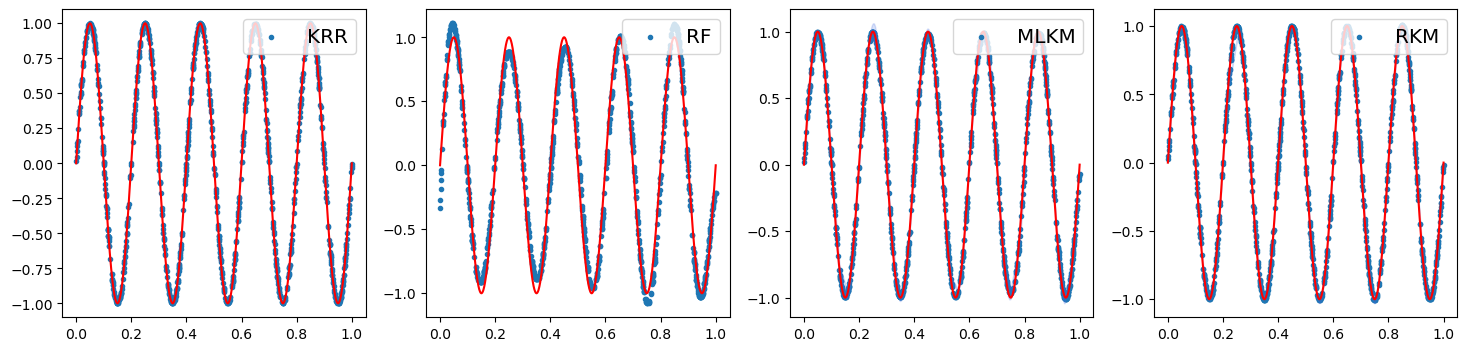

In [228]:
fig,ax=plt.subplots(1,4, figsize=(18, 4))
plot_x=np.linspace(0,1,1000)
#ax[0].scatter(calibration_x,calibration_y,marker=".",color='gray',label='_nolegend_')
ax[0].scatter(data.T[0],krr_pred,marker=".")
ax[0].plot(plot_x,np.sin(plot_x*10*np.pi),color="red")
ax[0].legend(["KRR"],fontsize="x-large",loc='upper right')
#ax[1].scatter(calibration_x,calibration_y,marker=".",color='gray',label='_nolegend_')
ax[1].scatter(data.T[0],rf_pred,marker=".")
ax[1].plot(plot_x,np.sin(plot_x*10*np.pi),color="red")
ax[1].legend(["RF"],fontsize="x-large",loc='upper right')
#ax[2].scatter(calibration_x,calibration_y,marker=".",color='gray',label='_nolegend_')
ax[2].scatter(data.T[0],kernel_pred,marker=".")
ax[2].plot(plot_x,np.sin(plot_x*10*np.pi),color="red")
ax[2].legend(["MLKM"],fontsize="x-large",loc='upper right')
band=np.array([pred_xall,list(map(lambda x,y:x-y, pred_yall,dist)),list(map(lambda x,y:x+y, pred_yall,dist))]).T
sort_band=band[np.argsort(band[:,0])]
plot_x=np.linspace(0,1,1000)
ax[2].fill_between(sort_band.T[0],sort_band.T[1],sort_band.T[2],alpha=0.2,color='royalblue')
#ax[3].scatter(calibration_x,calibration_y,marker=".",color='gray',label='_nolegend_')
ax[3].scatter(data.T[0],rk_pred,marker=".")
ax[3].plot(plot_x,np.sin(plot_x*10*np.pi),color="red")
ax[3].legend(["RKM"],fontsize="x-large",loc='upper right')
band=np.array([pred_xall2,list(map(lambda x,y:x-y, pred_yall2,dist2)),list(map(lambda x,y:x+y, pred_yall2,dist2))]).T
sort_band=band[np.argsort(band[:,0])]
plot_x=np.linspace(0,1,1000)
ax[3].fill_between(sort_band.T[0],sort_band.T[1],sort_band.T[2],alpha=0.2,color='royalblue')
plt.show()

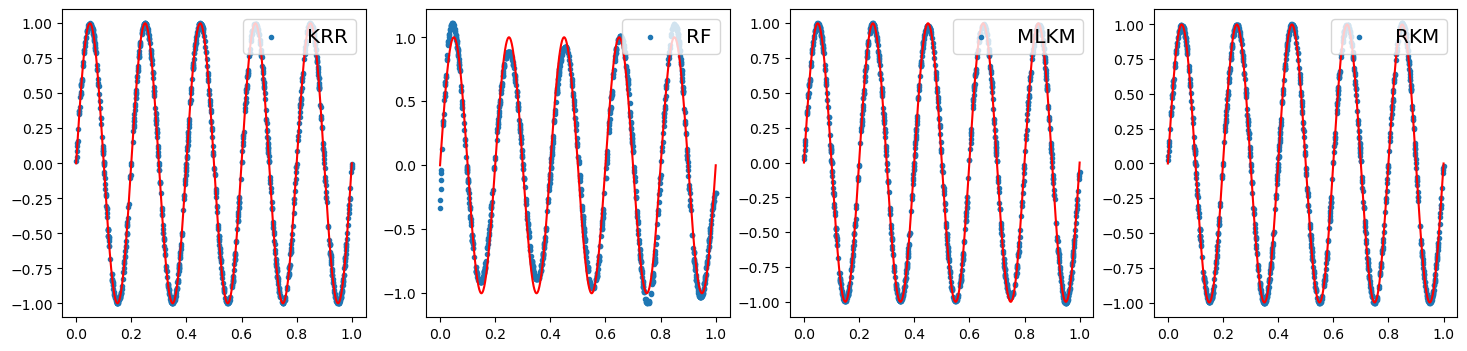

In [229]:
fig,ax=plt.subplots(1,4, figsize=(18, 4))
plot_x=np.linspace(0,1,1000)
ax[0].scatter(data.T[0],krr_pred,marker=".")
ax[0].plot(plot_x,np.sin(plot_x*10*np.pi),color="red")
ax[0].legend(["KRR"],fontsize="x-large",loc='upper right')
ax[1].scatter(data.T[0],rf_pred,marker=".")
ax[1].plot(plot_x,np.sin(plot_x*10*np.pi),color="red")
ax[1].legend(["RF"],fontsize="x-large",loc='upper right')
ax[2].scatter(data.T[0],kernel_pred,marker=".")
ax[2].plot(plot_x,np.sin(plot_x*10*np.pi),color="red")
ax[2].legend(["MLKM"],fontsize="x-large",loc='upper right')
ax[3].scatter(data.T[0],rk_pred,marker=".")
ax[3].plot(plot_x,np.sin(plot_x*10*np.pi),color="red")
ax[3].legend(["RKM"],fontsize="x-large",loc='upper right')
plt.show()

----------------------------

## Problem setup -- 2

data generation

In [183]:
def jumpfunc(x):
    return (np.sign (x-1/2))/2

np.random.seed(0)
data=np.random.uniform(0,1,(1000,1))
y=jumpfunc(data)

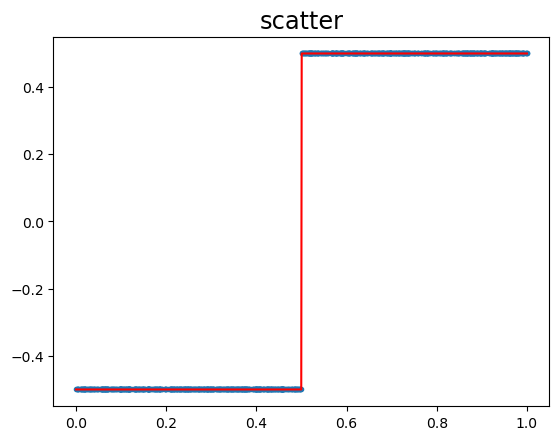

In [184]:
plot_x=np.linspace(0,1,1000)
plt.plot(plot_x,(np.sign (plot_x-1/2))/2,color="red")
plt.scatter(data.T[0],y,marker=".")
plt.title("scatter",fontsize="xx-large")
plt.show()

In [185]:
train_x=data
train_y=y
nntrain_x = torch.from_numpy(train_x).float()
nntrain_y = torch.squeeze(torch.from_numpy(train_y).float()) 

class mydataset(Dataset):
    def __init__(self, x, y):
        self._x = x
        self._y = y
        self._len = len(x)

    def __getitem__(self, item): 
        return self._x[item], self._y[item]

    def __len__(self):
        return self._len

## KRR

In [188]:
t0=time.time()
krr = KernelRidge(alpha=1e-3,kernel='rbf',gamma=100)
krr.fit(train_x, train_y)
krr_pred=krr.predict(train_x)
t1=time.time()-t0
print(mean_squared_error(train_y,krr_pred))
print("Time:",t1)

0.003923820909276111
Time: 0.06164741516113281


## RF

In [187]:
t0=time.time()
model=Ridge(alpha=1e-3)
rff=RandomFourierFeature(1,200,kernel='G',gamma=10)
feature=rff.transform(train_x)
model.fit(feature,train_y)
rf_pred=model.predict(feature)
t1=time.time()-t0
print(mean_squared_error(train_y,rf_pred))
print("Time:",t1)

0.009634185239716426
Time: 0.014075040817260742


# MLK

In [158]:
train_loader = DataLoader(mydataset(nntrain_x, nntrain_y),batch_size=128, shuffle=True)

rff1=RandomFourierFeature(1,64,kernel='G',gamma=10)
rff2=RandomFourierFeature(8,8,kernel='G',gamma=10)

class KernelNet(nn.Module): 
    def __init__(self):
        super(KernelNet, self).__init__()
        self.fc1 = nn.Linear(64, 8)
        self.fc2 = nn.Linear(8, 1)
        
    def forward(self, x):
        x = rff1.transform(x)
        x=self.fc1(x)
        x = rff2.transform(x)
        return self.fc2(x)


#initialize
def init_weights(m):
    if type(m) == nn.Conv2d:
        torch.nn.init.normal_(m.weight,mean=0,std=0.5)
    if type(m) == nn.Linear:
        torch.nn.init.uniform_(m.weight,a=-0.1,b=-0.1)
        m.bias.data.fill_(0.01)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = KernelNet()
net = net.to(device)
torch.manual_seed(1)
net.apply(init_weights)
print(net)
criterion=nn.MSELoss() 
optimizer=optim.SGD(net.parameters(),lr=1e-3,momentum=0.9,weight_decay=1e-3) #optim.Adam(...)

loss=[]
kernelnn_trainloss=[]
kernelnn_testloss=[]
t0 = time.time()
for epoch in range(2000): 
    for x, y in train_loader: #for batch, (x, y) in enumerate(train_loader): 
        x, y = x.to(device), y.to(device)
        # Compute prediction error
        y_pred = net(x)
        y_pred = torch.squeeze(y_pred)
        train_loss = criterion(y_pred, y)
        loss.append(train_loss)
        # Backpropagation
        optimizer.zero_grad() 
        train_loss.backward()
        optimizer.step()
    
    x0=torch.from_numpy(train_x[:]).float()
    with torch.no_grad():
        x0 = x0.to(device)
        pred = net(x0)
    
    x0=torch.from_numpy(train_x[:]).float()
    with torch.no_grad():
        x0 = x0.to(device)
        pred = net(x0)
    
    kernelnn_trainloss.append(mean_squared_error(pred,train_y))
    
    if epoch % 100 == 0:        
        print(f'''epoch {epoch}
            Train set - loss: {kernelnn_trainloss[-1]}
            ''')
        
    
dnn_fit = time.time() - t0
print("KernelNet complexity and model fitted in %.3f s" % dnn_fit)

KernelNet(
  (fc1): Linear(in_features=64, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=1, bias=True)
)
epoch 0
            Train set - loss: 0.2439363249210094
            
epoch 100
            Train set - loss: 0.004107388753027777
            
epoch 200
            Train set - loss: 0.0034785900794395827
            
epoch 300
            Train set - loss: 0.0030992227203151153
            
epoch 400
            Train set - loss: 0.0027876653937251874
            
epoch 500
            Train set - loss: 0.002532401866753988
            
epoch 600
            Train set - loss: 0.00233485789363409
            
epoch 700
            Train set - loss: 0.0022375493840412802
            
epoch 800
            Train set - loss: 0.0021694476581196618
            
epoch 900
            Train set - loss: 0.002129315220157792
            
epoch 1000
            Train set - loss: 0.0020942186247352185
            
epoch 1100
            Train set - loss: 0.00206835839

In [159]:
kernel_x0=torch.from_numpy(train_x[:]).float()
with torch.no_grad():
    kernel_x0 = kernel_x0.to(device)
    kernel_pred = net(kernel_x0)
    print(np.array(kernel_pred).reshape(-1))

[ 0.45407128  0.50182974  0.4824908   0.4490028  -0.49287027  0.5165682
 -0.5069939   0.4931386   0.49377957 -0.5201101   0.49772516  0.523315
  0.5166696   0.5000475  -0.50291157 -0.50754714 -0.5082093   0.4890668
  0.49645323  0.50945264  0.504282    0.49924263 -0.49158213  0.49622667
 -0.49708673  0.5138645  -0.4990467   0.50435174  0.55787337 -0.4831676
 -0.49616352  0.4973695  -0.4818477   0.51737595 -0.5088557   0.48486882
  0.48062298  0.48414993  0.5047546   0.49175707 -0.48977327 -0.5070772
  0.5024213  -0.49647215  0.49984676  0.49585024 -0.5003394  -0.496051
 -0.5095964  -0.49752942  0.5200234  -0.50663996  0.5071557  -0.503495
 -0.500288   -0.5029248   0.51438683 -0.49619666 -0.5170039  -0.49728814
 -0.50270426 -0.49980745  0.51173156 -0.4976066  -0.5000449  -0.5073887
  0.4929215  -0.5054824   0.4901262  -0.50582784  0.5019926  -0.5336022
  0.5023181   0.48100907  0.5024369  -0.4939949  -0.50033635 -0.49665314
 -0.5061226  -0.4969751  -0.5085422  -0.48300856 -0.4988063   0

In [160]:
##calibration set
np.random.seed(1)
calibration_x=np.random.uniform(0,1,(1000,1))
calibration_y=jumpfunc(calibration_x)

##conformal prediction
#predict

coverage=0
par=optimizer.param_groups[0]['params']
for i in range(len(train_x)):
    x0=torch.from_numpy(train_x[i:1+i]).float()
    x0 = x0.to(device)
    pred = net(x0)
    fi=torch.tensor([])
    for j in range(len(par)):
        par[j].grad.data.zero_()
    pred.backward()   
    for j in range(len(par)): 
        fi=torch.cat([fi,par[j].grad.reshape(-1)])
    fi=fi.reshape(1,-1)
    if i==0:
        Fi=fi
    else:
        Fi=torch.cat([Fi,fi])   
temp=torch.linalg.inv(Fi.T @ Fi)

mark=0
score=torch.tensor([])
for i in tqdm(range(len(train_x))):
    x0=torch.from_numpy(train_x[i:i+1]).float()
    x0 = x0.to(device)
    pred = net(x0)
    par=optimizer.param_groups[0]['params']
    f0=torch.tensor([])
    for j in range(len(par)):
        par[j].grad.data.zero_()
    pred.backward()
    for j in range(len(par)):
        f0=torch.cat([f0,par[j].grad.reshape(-1)])
    f0=f0.reshape(-1,1)
    fFFf=f0.T @ temp @ f0
    if fFFf < 0:
        continue
    score=torch.cat([score,np.abs(pred.detach().numpy()[0][0]-train_y[i])/np.sqrt(kernelnn_trainloss[-1])/np.sqrt(fFFf+1)])
    mark=mark+1
score=score.reshape(-1)
sorted_score, sorted_indices=torch.sort(score)
q=(len(score)+1)*0.95
a=sorted_score[int(np.ceil(q))]



pred_xall=[]
pred_yall=[]
true_yall=[]
dist=[]
mark=0
length=[]
for i in tqdm(range(len(calibration_x))):
    x0=torch.from_numpy(calibration_x[i:i+1]).float()
    x0 = x0.to(device)
    pred = net(x0)
    par=optimizer.param_groups[0]['params']
    f0=torch.tensor([])
    for j in range(len(par)):
        par[j].grad.data.zero_()
    pred.backward()
    for j in range(len(par)):
        f0=torch.cat([f0,par[j].grad.reshape(-1)])
    f0=f0.reshape(-1,1)

    fFFf=f0.T @ temp @ f0
    
    if fFFf < 0:
        continue
    mark=mark+1
    dd=(np.sqrt(kernelnn_trainloss[-1])*np.sqrt(fFFf+1)*a).detach().numpy()[0][0]
    length.append(2*dd)
    
    #coverage
    if pred.detach().numpy()[0][0]-dd<calibration_y[i] and pred.detach().numpy()[0][0]+dd>calibration_y[i]:
        coverage=coverage+1
    pred_xall.append(calibration_x[i][0])
    pred_yall.append(pred.detach().numpy()[0][0])
    true_yall.append(calibration_y[i])
    dist.append(dd)
coverage=coverage/mark


print("length",np.mean(length))
print("95 coverage",coverage)


100%|██████████| 1000/1000 [00:00<00:00, 1500.72it/s]

length 0.08423637094632214
95 coverage 0.9534412955465587


## RK

In [161]:
train_loader = DataLoader(mydataset(nntrain_x, nntrain_y),batch_size=128, shuffle=True)

rff0=RandomFourierFeature(1,64,kernel='G',gamma=10)
rff1=RandomFourierFeature(8,8,kernel='G',gamma=10)

class ResidualBlock(nn.Module):
    def __init__(self,infeatures,outfeatures,rff):
        super(ResidualBlock,self).__init__()
        self.infeatures = infeatures
        self.outfeatures = outfeatures
        self.rff=rff
        
        self.fc1 = nn.Linear(infeatures,outfeatures)
        self.fc2 = nn.Linear(outfeatures,outfeatures)
    
    def forward(self, x):
        rff=self.rff
        x = self.fc1(x)
        y = rff.transform(x)
        y = self.fc2(y)
        return x+y

class ResKernelNet(nn.Module): 
    def __init__(self):
        super(ResKernelNet, self).__init__()
        self.rblock1 = ResidualBlock(64,8,rff1)
        self.fc2 =nn.Linear(8,1)
 
    def forward(self, x):
        x = rff0.transform(x)
        x = self.rblock1(x)
        return self.fc2(x)

#initialize
def init_weights(m):
    if type(m) == nn.Conv2d:
        torch.nn.init.normal_(m.weight,mean=0,std=0.5)
    if type(m) == nn.Linear:
        torch.nn.init.uniform_(m.weight,a=-0.5,b=0.5)
        m.bias.data.fill_(0.01)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = ResKernelNet()
net = net.to(device)
torch.manual_seed(1)
#net.apply(init_weights)
print(net)
criterion=nn.MSELoss() 
optimizer=optim.SGD(net.parameters(),lr=5e-3,momentum=0.9,weight_decay=1e-3) #optim.Adam(...)

loss=[]
reskernel_trainloss=[]
reskernel_testloss=[]
t0 = time.time()
for epoch in range(2000): 
    for x, y in train_loader: #for batch, (x, y) in enumerate(train_loader): 
        x, y = x.to(device), y.to(device)
        # Compute prediction error
        y_pred = net(x)
        y_pred = torch.squeeze(y_pred)
        train_loss = criterion(y_pred, y)
        loss.append(train_loss)
        # Backpropagation
        optimizer.zero_grad() 
        train_loss.backward()
        optimizer.step()
    
    x0=torch.from_numpy(train_x[:]).float()
    with torch.no_grad():
        x0 = x0.to(device)
        pred = net(x0)
    
    reskernel_trainloss.append(mean_squared_error(pred,train_y))
    
    if epoch % 100 == 0:        
        print(f'''epoch {epoch}
            Train set - loss: {reskernel_trainloss[-1]}
            ''')
        
    
dnn_fit = time.time() - t0
print("Residual KernelNet complexity and model fitted in %.3f s" % dnn_fit)

ResKernelNet(
  (rblock1): ResidualBlock(
    (fc1): Linear(in_features=64, out_features=8, bias=True)
    (fc2): Linear(in_features=8, out_features=8, bias=True)
  )
  (fc2): Linear(in_features=8, out_features=1, bias=True)
)
epoch 0
            Train set - loss: 0.15033463264782915
            
epoch 100
            Train set - loss: 0.0023027615360281264
            
epoch 200
            Train set - loss: 0.001957487080458616
            
epoch 300
            Train set - loss: 0.0017451694360398067
            
epoch 400
            Train set - loss: 0.001653285736014594
            
epoch 500
            Train set - loss: 0.001728202360214236
            
epoch 600
            Train set - loss: 0.0014281499806725179
            
epoch 700
            Train set - loss: 0.001472266865717714
            
epoch 800
            Train set - loss: 0.0013202300394006402
            
epoch 900
            Train set - loss: 0.0013652863290669463
            
epoch 1000
            Train se

In [162]:
rk_x0=torch.from_numpy(train_x[:]).float()
with torch.no_grad():
    rk_x0 = rk_x0.to(device)
    rk_pred = net(rk_x0)
    print(np.array(rk_pred).reshape(-1))

[ 0.5291437   0.4990011   0.49948615  0.51778656 -0.5227427   0.50207907
 -0.4773177   0.49531102  0.49620855 -0.49347526  0.4992481   0.45778012
  0.5034021   0.49857235 -0.501762   -0.5046101  -0.50501686  0.50056636
  0.5046862   0.49299714  0.49175388  0.49546874 -0.49370807  0.50407034
 -0.49873108  0.4964253  -0.50779545  0.49945542  0.50939965 -0.5268451
 -0.48811215  0.5052991  -0.5178082   0.5026066  -0.50578487  0.49892473
  0.50093174  0.4992771   0.49938095  0.49333495 -0.506316   -0.47824854
  0.5003257  -0.49387562  0.49924582  0.49598294 -0.5010355  -0.50248003
 -0.49621373 -0.51039577  0.49924558 -0.47613007  0.49510637 -0.49942267
 -0.5002985  -0.5059708   0.5066109  -0.4910137  -0.45381695 -0.4956386
 -0.5068906  -0.4979087   0.5065984  -0.5062638  -0.4948138  -0.5114071
  0.4941428  -0.5011814   0.5032133  -0.50157243  0.49180567 -0.43875426
  0.49178034  0.5003185   0.49643433 -0.48886162 -0.48810363 -0.49923515
 -0.49073523 -0.49884063 -0.4957884  -0.52627903 -0.49

In [163]:
##calibration set
np.random.seed(1)
calibration_x=np.random.uniform(0,1,(1000,1))
calibration_y=jumpfunc(calibration_x)

##conformal prediction
#predict

coverage=0
par=optimizer.param_groups[0]['params']
for i in range(len(train_x)):
    x0=torch.from_numpy(train_x[i:1+i]).float()
    x0 = x0.to(device)
    pred = net(x0)
    fi=torch.tensor([])
    for j in range(len(par)):
        par[j].grad.data.zero_()
    pred.backward()   
    for j in range(len(par)): 
        fi=torch.cat([fi,par[j].grad.reshape(-1)])
    fi=fi.reshape(1,-1)
    if i==0:
        Fi=fi
    else:
        Fi=torch.cat([Fi,fi])   
temp=torch.linalg.inv(Fi.T @ Fi)

mark=0
score=torch.tensor([])
for i in tqdm(range(len(train_x))):
    x0=torch.from_numpy(train_x[i:i+1]).float()
    x0 = x0.to(device)
    pred = net(x0)
    par=optimizer.param_groups[0]['params']
    f0=torch.tensor([])
    for j in range(len(par)):
        par[j].grad.data.zero_()
    pred.backward()
    for j in range(len(par)):
        f0=torch.cat([f0,par[j].grad.reshape(-1)])
    f0=f0.reshape(-1,1)
    fFFf=f0.T @ temp @ f0
    if fFFf < 0:
        continue
    score=torch.cat([score,np.abs(pred.detach().numpy()[0][0]-train_y[i])/np.sqrt(reskernel_trainloss[-1])/np.sqrt(fFFf+1)])
    mark=mark+1
score=score.reshape(-1)
sorted_score, sorted_indices=torch.sort(score)
q=(len(score)+1)*0.95
a=sorted_score[int(np.ceil(q))]



pred_xall2=[]
pred_yall2=[]
true_yall2=[]
dist2=[]
mark=0
length=[]
for i in tqdm(range(len(calibration_x))):
    x0=torch.from_numpy(calibration_x[i:i+1]).float()
    x0 = x0.to(device)
    pred = net(x0)
    par=optimizer.param_groups[0]['params']
    f0=torch.tensor([])
    for j in range(len(par)):
        par[j].grad.data.zero_()
    pred.backward()
    for j in range(len(par)):
        f0=torch.cat([f0,par[j].grad.reshape(-1)])
    f0=f0.reshape(-1,1)

    fFFf=f0.T @ temp @ f0
    
    if fFFf < 0:
        continue
    mark=mark+1
    dd=(np.sqrt(reskernel_trainloss[-1])*np.sqrt(fFFf+1)*a).detach().numpy()[0][0]
    length.append(2*dd)
    
    #coverage
    if pred.detach().numpy()[0][0]-dd<calibration_y[i] and pred.detach().numpy()[0][0]+dd>calibration_y[i]:
        coverage=coverage+1
    pred_xall2.append(calibration_x[i][0])
    pred_yall2.append(pred.detach().numpy()[0][0])
    true_yall2.append(calibration_y[i])
    dist2.append(dd)
coverage=coverage/mark


print("length",np.mean(length))
print("95 coverage",coverage)


100%|██████████| 1000/1000 [00:00<00:00, 1200.51it/s]

length 0.0718646205496043
95 coverage 0.9528688524590164


## Comparison

In [164]:
print(mean_squared_error(kernel_pred,train_y))
print(mean_squared_error(rk_pred,train_y))

0.0017933423598680256
0.0012416514141674168


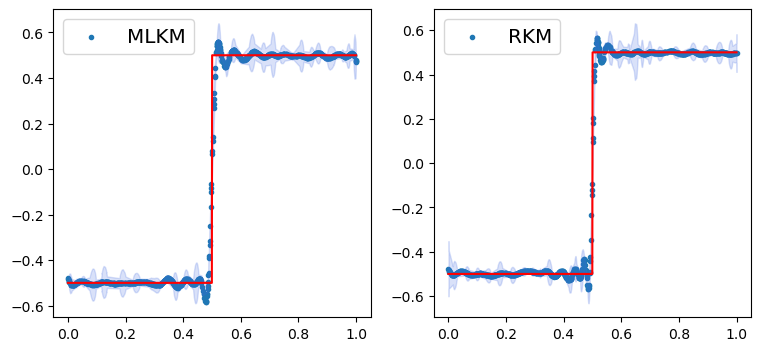

In [165]:
fig,ax=plt.subplots(1,2, figsize=(9, 4))
plot_x=np.linspace(0,1,1000)
#ax[0].scatter(calibration_x,calibration_y,marker=".",color='gray',label='_nolegend_')
ax[0].scatter(data.T[0],kernel_pred,marker=".")
ax[0].plot(plot_x,np.sign(plot_x-1/2)/2,color="red")
ax[0].legend(["MLKM"],fontsize="x-large")
band=np.array([pred_xall,list(map(lambda x,y:x-y, pred_yall,dist)),list(map(lambda x,y:x+y, pred_yall,dist))]).T
sort_band=band[np.argsort(band[:,0])]
plot_x=np.linspace(0,1,1000)
ax[0].fill_between(sort_band.T[0],sort_band.T[1],sort_band.T[2],alpha=0.2,color='royalblue')
#ax[1].scatter(calibration_x,calibration_y,marker=".",color='gray',label='_nolegend_')
ax[1].scatter(data.T[0],rk_pred,marker=".")
ax[1].plot(plot_x,np.sign(plot_x-1/2)/2,color="red")
ax[1].legend(["RKM"],fontsize="x-large")
band=np.array([pred_xall2,list(map(lambda x,y:x-y, pred_yall2,dist2)),list(map(lambda x,y:x+y, pred_yall2,dist2))]).T
sort_band=band[np.argsort(band[:,0])]
plot_x=np.linspace(0,1,1000)
ax[1].fill_between(sort_band.T[0],sort_band.T[1],sort_band.T[2],alpha=0.2,color='royalblue')
plt.show()

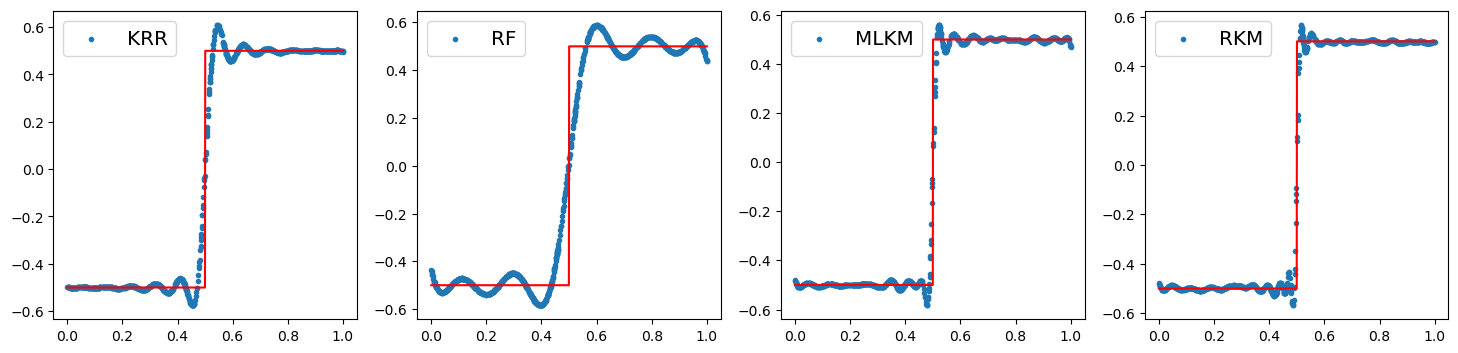

In [190]:
fig,ax=plt.subplots(1,4, figsize=(18, 4))
plot_x=np.linspace(0,1,1000)
#ax[0].scatter(calibration_x,calibration_y,marker=".",color='gray',label='_nolegend_')
ax[0].scatter(data.T[0],krr_pred,marker=".")
ax[0].plot(plot_x,np.sign(plot_x-1/2)/2,color="red")
ax[0].legend(["KRR"],fontsize="x-large")
#ax[1].scatter(calibration_x,calibration_y,marker=".",color='gray',label='_nolegend_')
ax[1].scatter(data.T[0],rf_pred,marker=".")
ax[1].plot(plot_x,np.sign(plot_x-1/2)/2,color="red")
ax[1].legend(["RF"],fontsize="x-large")
#ax[2].scatter(calibration_x,calibration_y,marker=".",color='gray',label='_nolegend_')
ax[2].scatter(data.T[0],kernel_pred,marker=".")
ax[2].plot(plot_x,np.sign(plot_x-1/2)/2,color="red")
ax[2].legend(["MLKM"],fontsize="x-large")
band=np.array([pred_xall,list(map(lambda x,y:x-y, pred_yall,dist)),list(map(lambda x,y:x+y, pred_yall,dist))]).T
sort_band=band[np.argsort(band[:,0])]
plot_x=np.linspace(0,1,1000)
#ax[2].fill_between(sort_band.T[0],sort_band.T[1],sort_band.T[2],alpha=0.2,color='royalblue')
#ax[3].scatter(calibration_x,calibration_y,marker=".",color='gray',label='_nolegend_')
ax[3].scatter(data.T[0],rk_pred,marker=".")
ax[3].plot(plot_x,np.sign(plot_x-1/2)/2,color="red")
ax[3].legend(["RKM"],fontsize="x-large")
band=np.array([pred_xall2,list(map(lambda x,y:x-y, pred_yall2,dist2)),list(map(lambda x,y:x+y, pred_yall2,dist2))]).T
sort_band=band[np.argsort(band[:,0])]
plot_x=np.linspace(0,1,1000)
#ax[3].fill_between(sort_band.T[0],sort_band.T[1],sort_band.T[2],alpha=0.2,color='royalblue')
plt.show()

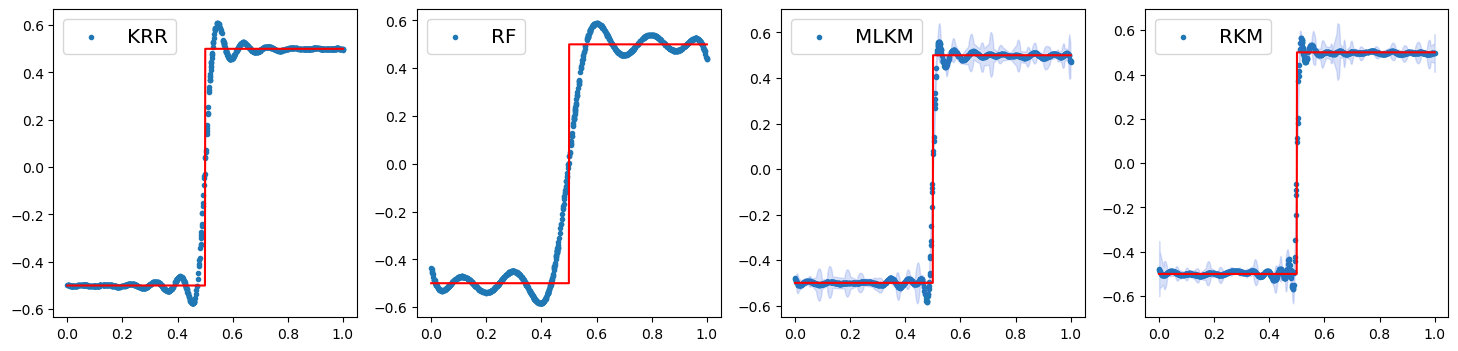

In [189]:
fig,ax=plt.subplots(1,4, figsize=(18, 4))
plot_x=np.linspace(0,1,1000)
#ax[0].scatter(calibration_x,calibration_y,marker=".",color='gray',label='_nolegend_')
ax[0].scatter(data.T[0],krr_pred,marker=".")
ax[0].plot(plot_x,np.sign(plot_x-1/2)/2,color="red")
ax[0].legend(["KRR"],fontsize="x-large")
#ax[1].scatter(calibration_x,calibration_y,marker=".",color='gray',label='_nolegend_')
ax[1].scatter(data.T[0],rf_pred,marker=".")
ax[1].plot(plot_x,np.sign(plot_x-1/2)/2,color="red")
ax[1].legend(["RF"],fontsize="x-large")
#ax[2].scatter(calibration_x,calibration_y,marker=".",color='gray',label='_nolegend_')
ax[2].scatter(data.T[0],kernel_pred,marker=".")
ax[2].plot(plot_x,np.sign(plot_x-1/2)/2,color="red")
ax[2].legend(["MLKM"],fontsize="x-large")
band=np.array([pred_xall,list(map(lambda x,y:x-y, pred_yall,dist)),list(map(lambda x,y:x+y, pred_yall,dist))]).T
sort_band=band[np.argsort(band[:,0])]
plot_x=np.linspace(0,1,1000)
ax[2].fill_between(sort_band.T[0],sort_band.T[1],sort_band.T[2],alpha=0.2,color='royalblue')
#ax[3].scatter(calibration_x,calibration_y,marker=".",color='gray',label='_nolegend_')
ax[3].scatter(data.T[0],rk_pred,marker=".")
ax[3].plot(plot_x,np.sign(plot_x-1/2)/2,color="red")
ax[3].legend(["RKM"],fontsize="x-large")
band=np.array([pred_xall2,list(map(lambda x,y:x-y, pred_yall2,dist2)),list(map(lambda x,y:x+y, pred_yall2,dist2))]).T
sort_band=band[np.argsort(band[:,0])]
plot_x=np.linspace(0,1,1000)
ax[3].fill_between(sort_band.T[0],sort_band.T[1],sort_band.T[2],alpha=0.2,color='royalblue')
plt.show()

----------------------------

## Problem setup -- 3

data generation

In [ ]:
def func(x):
    return x[:,0]**2

np.random.seed(0)
data=np.random.uniform(0,1,(1000,1))
noise=np.random.randn(1000)*0.2
y=func(data)+noise

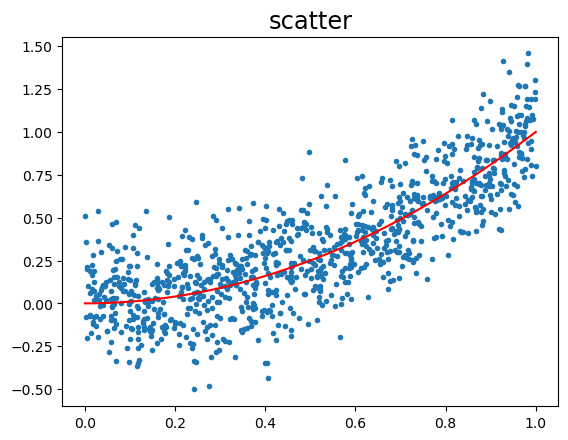

In [ ]:
plot_x=np.linspace(0,1,1000)
plt.plot(plot_x,plot_x**2,color="red")
plt.scatter(data.T[0],y,marker=".")
plt.title("scatter",fontsize="xx-large")
plt.show()

In [ ]:
train_x=data
train_y=y
nntrain_x = torch.from_numpy(train_x).float()
nntrain_y = torch.squeeze(torch.from_numpy(train_y).float()) 

class mydataset(Dataset):
    def __init__(self, x, y):
        self._x = x
        self._y = y
        self._len = len(x)

    def __getitem__(self, item): 
        return self._x[item], self._y[item]

    def __len__(self):
        return self._len

## KRR

In [ ]:
t0=time.time()
krr = KernelRidge(alpha=1e-3,kernel='rbf',gamma=1)
krr.fit(train_x, train_y)
krr_pred=krr.predict(train_x)
t1=time.time()-t0
print(mean_squared_error(train_y,krr_pred))
print("Time:",t1)

0.03691404483686368
Time: 0.08636021614074707


## RF

In [ ]:
t0=time.time()
model=Ridge(alpha=1e-3)
rff=RandomFourierFeature(1,200,kernel='G',gamma=1)
feature=rff.transform(train_x)
model.fit(feature,train_y)
rf_pred=model.predict(feature)
t1=time.time()-t0
print(mean_squared_error(train_y,rf_pred))
print("Time:",t1)

0.037053885207466296
Time: 0.011918783187866211


# MLK

In [ ]:
train_loader = DataLoader(mydataset(nntrain_x, nntrain_y),batch_size=128, shuffle=True)

rff1=RandomFourierFeature(1,64,kernel='G',gamma=1)
rff2=RandomFourierFeature(8,8,kernel='G',gamma=2)

class KernelNet(nn.Module): 
    def __init__(self):
        super(KernelNet, self).__init__()
        self.fc1 = nn.Linear(64, 8)
        self.fc2 = nn.Linear(8, 1)
        
    def forward(self, x):
        x = rff1.transform(x)
        x=self.fc1(x)
        x = rff2.transform(x)
        return self.fc2(x)


#initialize
def init_weights(m):
    if type(m) == nn.Conv2d:
        torch.nn.init.normal_(m.weight,mean=0,std=0.5)
    if type(m) == nn.Linear:
        torch.nn.init.uniform_(m.weight,a=-0.5,b=-0.5)
        m.bias.data.fill_(0.01)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = KernelNet()
net = net.to(device)
torch.manual_seed(1)
net.apply(init_weights)
print(net)
criterion=nn.MSELoss() 
optimizer=optim.SGD(net.parameters(),lr=5e-3,momentum=0.9,weight_decay=1e-3) #optim.Adam(...)

loss=[]
kernelnn_trainloss=[]
kernelnn_testloss=[]
t0 = time.time()
for epoch in range(2000): 
    for x, y in train_loader: #for batch, (x, y) in enumerate(train_loader): 
        x, y = x.to(device), y.to(device)
        # Compute prediction error
        y_pred = net(x)
        y_pred = torch.squeeze(y_pred)
        train_loss = criterion(y_pred, y)
        loss.append(train_loss)
        # Backpropagation
        optimizer.zero_grad() 
        train_loss.backward()
        optimizer.step()
    
    x0=torch.from_numpy(train_x[:]).float()
    with torch.no_grad():
        x0 = x0.to(device)
        pred = net(x0)
    
    x0=torch.from_numpy(train_x[:]).float()
    with torch.no_grad():
        x0 = x0.to(device)
        pred = net(x0)
    
    kernelnn_trainloss.append(mean_squared_error(pred,train_y))
    
    if epoch % 100 == 0:        
        print(f'''epoch {epoch}
            Train set - loss: {kernelnn_trainloss[-1]}
            ''')
        
    
dnn_fit = time.time() - t0
print("KernelNet complexity and model fitted in %.3f s" % dnn_fit)

KernelNet(
  (fc1): Linear(in_features=64, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=1, bias=True)
)
epoch 0
            Train set - loss: 0.18813896393966734
            
epoch 100
            Train set - loss: 0.03748585915773033
            
epoch 200
            Train set - loss: 0.037253571760729284
            
epoch 300
            Train set - loss: 0.03712325235190846
            
epoch 400
            Train set - loss: 0.03723349518660403
            
epoch 500
            Train set - loss: 0.037053862213656016
            
epoch 600
            Train set - loss: 0.037009089451035704
            
epoch 700
            Train set - loss: 0.03698966506639894
            
epoch 800
            Train set - loss: 0.03700707670290149
            
epoch 900
            Train set - loss: 0.03700954903010879
            
epoch 1000
            Train set - loss: 0.03700153205760441
            
epoch 1100
            Train set - loss: 0.03707828448627635
    

In [ ]:
kernel_x0=torch.from_numpy(train_x[:]).float()
with torch.no_grad():
    kernel_x0 = kernel_x0.to(device)
    kernel_pred = net(kernel_x0)
    print(np.array(kernel_pred).reshape(-1))

[0.29515594 0.5008951  0.3543604  0.29108748 0.18015203 0.40658343
 0.19152692 0.8054089  0.9487477  0.14930174 0.62170124 0.27485862
 0.31552958 0.87236804 0.04022326 0.03831176 0.05314347 0.6935767
 0.598964   0.76333106 0.9786364  0.6343968  0.21184877 0.60289884
 0.03745124 0.39907134 0.03935362 0.9106101  0.26786816 0.17299646
 0.07681438 0.59249574 0.20722684 0.31595045 0.05366151 0.37184805
 0.36527187 0.37101138 0.9087601  0.45378348 0.13237208 0.1910671
 0.4757002  0.04208648 0.43357587 0.438712   0.0547549  0.03798486
 0.10415426 0.13526535 0.31785905 0.19236884 0.99799    0.0374413
 0.05425687 0.04206093 0.41578072 0.0715926  0.21608382 0.06770888
 0.04164681 0.03732383 0.41993243 0.03877901 0.05043888 0.13876247
 0.67264545 0.03763518 0.7032894  0.03768595 0.9743361  0.21815062
 0.9749372  0.3567772  0.5369473  0.04707563 0.08593521 0.037517
 0.09309316 0.03746542 0.10568002 0.17268226 0.04135631 0.46846962
 0.31397387 0.07721356 0.26924923 0.03780803 0.32413048 0.8797701
 

### Conformal confidence bands for MLKM

100%|██████████| 1000/1000 [00:00<00:00, 1595.67it/s]


length 0.7888968911136981
95 coverage 0.9513064133016627


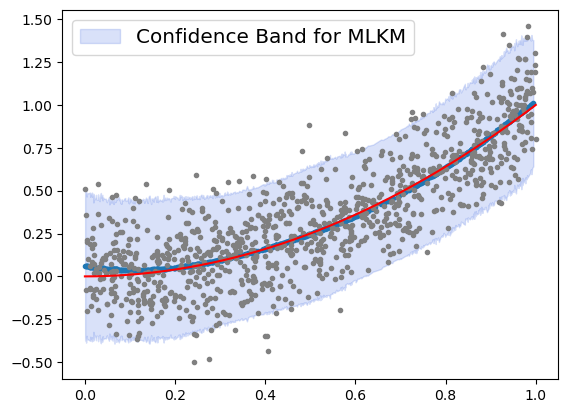

In [ ]:
##calibration set
np.random.seed(0)
calibration_x=np.random.uniform(0,1,(1000,1))
calibration_noise=np.random.randn(1000)*0.2
calibration_y=func(calibration_x)+calibration_noise

##conformal prediction
#predict

coverage=0
par=optimizer.param_groups[0]['params']
for i in range(len(train_x)):
    x0=torch.from_numpy(train_x[i:1+i]).float()
    x0 = x0.to(device)
    pred = net(x0)
    fi=torch.tensor([])
    for j in range(len(par)):
        par[j].grad.data.zero_()
    pred.backward()   
    for j in range(len(par)): 
        fi=torch.cat([fi,par[j].grad.reshape(-1)])
    fi=fi.reshape(1,-1)
    if i==0:
        Fi=fi
    else:
        Fi=torch.cat([Fi,fi])   
temp=torch.linalg.inv(Fi.T @ Fi)

mark=0
score=torch.tensor([])
for i in tqdm(range(len(train_x))):
    x0=torch.from_numpy(train_x[i:i+1]).float()
    x0 = x0.to(device)
    pred = net(x0)
    par=optimizer.param_groups[0]['params']
    f0=torch.tensor([])
    for j in range(len(par)):
        par[j].grad.data.zero_()
    pred.backward()
    for j in range(len(par)):
        f0=torch.cat([f0,par[j].grad.reshape(-1)])
    f0=f0.reshape(-1,1)
    fFFf=f0.T @ temp @ f0
    if fFFf < 0:
        continue
    score=torch.cat([score,np.abs(pred.detach().numpy()[0][0]-train_y[i])/np.sqrt(kernelnn_trainloss[-1])/np.sqrt(fFFf+1)])
    mark=mark+1
score=score.reshape(-1)
sorted_score, sorted_indices=torch.sort(score)
q=(len(score)+1)*0.95
a=sorted_score[int(np.ceil(q))]



pred_xall=[]
pred_yall=[]
true_yall=[]
dist=[]
mark=0
length=[]
for i in tqdm(range(len(calibration_x))):
    x0=torch.from_numpy(calibration_x[i:i+1]).float()
    x0 = x0.to(device)
    pred = net(x0)
    par=optimizer.param_groups[0]['params']
    f0=torch.tensor([])
    for j in range(len(par)):
        par[j].grad.data.zero_()
    pred.backward()
    for j in range(len(par)):
        f0=torch.cat([f0,par[j].grad.reshape(-1)])
    f0=f0.reshape(-1,1)

    fFFf=f0.T @ temp @ f0
    
    if fFFf < 0:
        continue
    mark=mark+1
    dd=(np.sqrt(kernelnn_trainloss[-1])*np.sqrt(fFFf+1)*a).detach().numpy()[0][0]
    length.append(2*dd)
    
    #coverage
    if pred.detach().numpy()[0][0]-dd<calibration_y[i] and pred.detach().numpy()[0][0]+dd>calibration_y[i]:
        coverage=coverage+1
    pred_xall.append(calibration_x[i][0])
    pred_yall.append(pred.detach().numpy()[0][0])
    true_yall.append(calibration_y[i])
    dist.append(dd)
coverage=coverage/mark


print("length",np.mean(length))
print("95 coverage",coverage)

band=np.array([pred_xall,list(map(lambda x,y:x-y, pred_yall,dist)),list(map(lambda x,y:x+y, pred_yall,dist))]).T
sort_band=band[np.argsort(band[:,0])]
plot_x=np.linspace(0,1,1000)
plt.fill_between(sort_band.T[0],sort_band.T[1],sort_band.T[2],alpha=0.2,color='royalblue')
plt.scatter(pred_xall,pred_yall,marker=".")
plt.plot(plot_x,plot_x**2,color="red")
plt.scatter(calibration_x,calibration_y,marker=".",color='gray')
plt.legend(["Confidence Band for MLKM"],fontsize="x-large")
plt.show()

## RK

In [ ]:
train_loader = DataLoader(mydataset(nntrain_x, nntrain_y),batch_size=128, shuffle=True)

rff0=RandomFourierFeature(1,64,kernel='G',gamma=1)
rff1=RandomFourierFeature(8,8,kernel='G',gamma=2)

class ResidualBlock(nn.Module):
    def __init__(self,infeatures,outfeatures,rff):
        super(ResidualBlock,self).__init__()
        self.infeatures = infeatures
        self.outfeatures = outfeatures
        self.rff=rff
        
        self.fc1 = nn.Linear(infeatures,outfeatures)
        self.fc2 = nn.Linear(outfeatures,outfeatures)
    
    def forward(self, x):
        rff=self.rff
        x = self.fc1(x)
        y = rff.transform(x)
        y = self.fc2(y)
        return x+y

class ResKernelNet(nn.Module): 
    def __init__(self):
        super(ResKernelNet, self).__init__()
        self.rblock1 = ResidualBlock(64,8,rff1)
        self.fc2 =nn.Linear(8,1)
 
    def forward(self, x):
        x = rff0.transform(x)
        x = self.rblock1(x)
        return self.fc2(x)

#initialize
def init_weights(m):
    if type(m) == nn.Conv2d:
        torch.nn.init.normal_(m.weight,mean=0,std=0.5)
    if type(m) == nn.Linear:
        torch.nn.init.uniform_(m.weight,a=-0.5,b=0.5)
        m.bias.data.fill_(0.01)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = ResKernelNet()
net = net.to(device)
torch.manual_seed(1)
#net.apply(init_weights)
print(net)
criterion=nn.MSELoss() 
optimizer=optim.SGD(net.parameters(),lr=5e-3,momentum=0.9,weight_decay=1e-3) #optim.Adam(...)

loss=[]
reskernel_trainloss=[]
reskernel_testloss=[]
t0 = time.time()
for epoch in range(2000): 
    for x, y in train_loader: #for batch, (x, y) in enumerate(train_loader): 
        x, y = x.to(device), y.to(device)
        # Compute prediction error
        y_pred = net(x)
        y_pred = torch.squeeze(y_pred)
        train_loss = criterion(y_pred, y)
        loss.append(train_loss)
        # Backpropagation
        optimizer.zero_grad() 
        train_loss.backward()
        optimizer.step()
    
    x0=torch.from_numpy(train_x[:]).float()
    with torch.no_grad():
        x0 = x0.to(device)
        pred = net(x0)
    
    reskernel_trainloss.append(mean_squared_error(pred,train_y))
    
    if epoch % 100 == 0:        
        print(f'''epoch {epoch}
            Train set - loss: {reskernel_trainloss[-1]}
            ''')
        
    
dnn_fit = time.time() - t0
print("Residual KernelNet complexity and model fitted in %.3f s" % dnn_fit)

ResKernelNet(
  (rblock1): ResidualBlock(
    (fc1): Linear(in_features=64, out_features=8, bias=True)
    (fc2): Linear(in_features=8, out_features=8, bias=True)
  )
  (fc2): Linear(in_features=8, out_features=1, bias=True)
)
epoch 0
            Train set - loss: 0.16671098664277123
            
epoch 100
            Train set - loss: 0.03746803434416377
            
epoch 200
            Train set - loss: 0.03738750878258408
            
epoch 300
            Train set - loss: 0.03735990020048685
            
epoch 400
            Train set - loss: 0.0373956189199979
            
epoch 500
            Train set - loss: 0.03732310564082019
            
epoch 600
            Train set - loss: 0.03733089709319255
            
epoch 700
            Train set - loss: 0.037309218661349286
            
epoch 800
            Train set - loss: 0.03748488596136195
            
epoch 900
            Train set - loss: 0.03736346040341844
            
epoch 1000
            Train set - loss: 0.03

In [ ]:
rk_x0=torch.from_numpy(train_x[:]).float()
with torch.no_grad():
    rk_x0 = rk_x0.to(device)
    rk_pred = net(rk_x0)
    print(np.array(rk_pred).reshape(-1))

[0.27709234 0.49926618 0.3411197  0.27275023 0.16055015 0.39805472
 0.17133078 0.7950007  0.9207672  0.13238329 0.62256336 0.25554413
 0.29897416 0.85434186 0.03299008 0.03430675 0.03049728 0.6920301
 0.5999874  0.75690603 0.94661295 0.63504106 0.19107531 0.60391545
 0.03768972 0.38987747 0.04129884 0.88771176 0.24819422 0.15387431
 0.07262505 0.59351087 0.18653244 0.29942802 0.03045991 0.3601913
 0.35301706 0.35927832 0.886104   0.44912127 0.11763048 0.17089091
 0.4725715  0.03225701 0.42733854 0.4328882  0.05548097 0.03912075
 0.09416938 0.12011568 0.30148846 0.17213655 0.9633634  0.03578323
 0.05508194 0.04441718 0.4080526  0.06859424 0.19526328 0.06559924
 0.04398417 0.03672146 0.41255918 0.04048565 0.05197036 0.1231391
 0.6720902  0.03526556 0.7012055  0.03516398 0.94289374 0.1973157
 0.94341385 0.34375358 0.5369098  0.03115419 0.07971009 0.03793705
 0.08533484 0.03774762 0.09540309 0.15358327 0.03250941 0.46485698
 0.2972957  0.07293371 0.24964286 0.03494938 0.30826968 0.8608246


100%|██████████| 1000/1000 [00:00<00:00, 1327.96it/s]


length 0.7701129329425317
95 coverage 0.9518518518518518


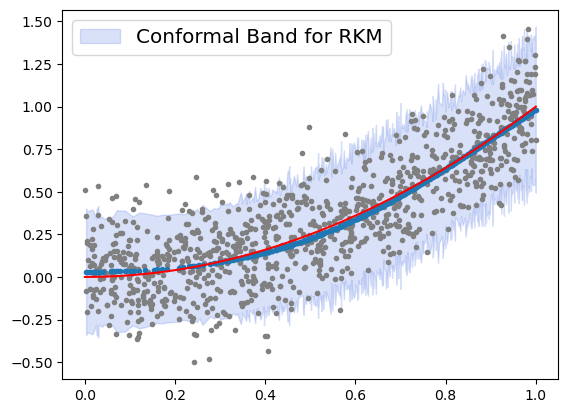

In [ ]:
##calibration set
np.random.seed(0)
calibration_x=np.random.uniform(0,1,(1000,1))
calibration_noise=np.random.randn(1000)*0.2
calibration_y=func(calibration_x)+calibration_noise

##conformal prediction
#predict

coverage=0
par=optimizer.param_groups[0]['params']
for i in range(len(train_x)):
    x0=torch.from_numpy(train_x[i:1+i]).float()
    x0 = x0.to(device)
    pred = net(x0)
    fi=torch.tensor([])
    for j in range(len(par)):
        par[j].grad.data.zero_()
    pred.backward()   
    for j in range(len(par)): 
        fi=torch.cat([fi,par[j].grad.reshape(-1)])
    fi=fi.reshape(1,-1)
    if i==0:
        Fi=fi
    else:
        Fi=torch.cat([Fi,fi])   
temp=torch.linalg.inv(Fi.T @ Fi)

mark=0
score=torch.tensor([])
for i in tqdm(range(len(train_x))):
    x0=torch.from_numpy(train_x[i:i+1]).float()
    x0 = x0.to(device)
    pred = net(x0)
    par=optimizer.param_groups[0]['params']
    f0=torch.tensor([])
    for j in range(len(par)):
        par[j].grad.data.zero_()
    pred.backward()
    for j in range(len(par)):
        f0=torch.cat([f0,par[j].grad.reshape(-1)])
    f0=f0.reshape(-1,1)
    fFFf=f0.T @ temp @ f0
    if fFFf < 0:
        continue
    score=torch.cat([score,np.abs(pred.detach().numpy()[0][0]-train_y[i])/np.sqrt(reskernel_trainloss[-1])/np.sqrt(fFFf+1)])
    mark=mark+1
score=score.reshape(-1)
sorted_score, sorted_indices=torch.sort(score)
q=(len(score)+1)*0.95
a=sorted_score[int(np.ceil(q))]



pred_xall2=[]
pred_yall2=[]
true_yall2=[]
dist2=[]
mark=0
length=[]
for i in tqdm(range(len(calibration_x))):
    x0=torch.from_numpy(calibration_x[i:i+1]).float()
    x0 = x0.to(device)
    pred = net(x0)
    par=optimizer.param_groups[0]['params']
    f0=torch.tensor([])
    for j in range(len(par)):
        par[j].grad.data.zero_()
    pred.backward()
    for j in range(len(par)):
        f0=torch.cat([f0,par[j].grad.reshape(-1)])
    f0=f0.reshape(-1,1)

    fFFf=f0.T @ temp @ f0
    
    if fFFf < 0:
        continue
    mark=mark+1
    dd=(np.sqrt(reskernel_trainloss[-1])*np.sqrt(fFFf+1)*a).detach().numpy()[0][0]
    length.append(2*dd)
    
    #coverage
    if pred.detach().numpy()[0][0]-dd<calibration_y[i] and pred.detach().numpy()[0][0]+dd>calibration_y[i]:
        coverage=coverage+1
    pred_xall2.append(calibration_x[i][0])
    pred_yall2.append(pred.detach().numpy()[0][0])
    true_yall2.append(calibration_y[i])
    dist2.append(dd)
coverage=coverage/mark


print("length",np.mean(length))
print("95 coverage",coverage)

band=np.array([pred_xall2,list(map(lambda x,y:x-y, pred_yall2,dist2)),list(map(lambda x,y:x+y, pred_yall2,dist2))]).T
sort_band=band[np.argsort(band[:,0])]
plot_x=np.linspace(0,1,1000)
plt.fill_between(sort_band.T[0],sort_band.T[1],sort_band.T[2],alpha=0.2,color='royalblue')
plt.scatter(calibration_x,calibration_y,marker=".",color='gray')
plt.scatter(pred_xall2,pred_yall2,marker=".")
plt.plot(plot_x,plot_x**2,color="red")
plt.legend(["Conformal Band for RKM"],fontsize="x-large")
plt.show()

In [ ]:
print(mean_squared_error(kernel_pred,train_y))
print(mean_squared_error(rk_pred,train_y))

0.03703832364903389
0.03737807757002789


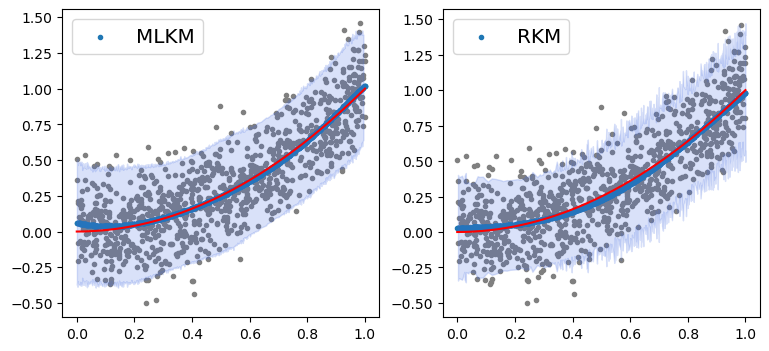

In [ ]:
fig,ax=plt.subplots(1,2, figsize=(9, 4))
plot_x=np.linspace(0,1,1000)
ax[0].scatter(calibration_x,calibration_y,marker=".",color='gray',label='_nolegend_')
ax[0].scatter(data.T[0],kernel_pred,marker=".")
ax[0].plot(plot_x,plot_x**2,color="red")
ax[0].legend(["MLKM"],fontsize="x-large")
band=np.array([pred_xall,list(map(lambda x,y:x-y, pred_yall,dist)),list(map(lambda x,y:x+y, pred_yall,dist))]).T
sort_band=band[np.argsort(band[:,0])]
plot_x=np.linspace(0,1,1000)
ax[0].fill_between(sort_band.T[0],sort_band.T[1],sort_band.T[2],alpha=0.2,color='royalblue')
ax[1].scatter(calibration_x,calibration_y,marker=".",color='gray',label='_nolegend_')
ax[1].scatter(data.T[0],rk_pred,marker=".")
ax[1].plot(plot_x,plot_x**2,color="red")
ax[1].legend(["RKM"],fontsize="x-large")
band=np.array([pred_xall2,list(map(lambda x,y:x-y, pred_yall2,dist2)),list(map(lambda x,y:x+y, pred_yall2,dist2))]).T
sort_band=band[np.argsort(band[:,0])]
plot_x=np.linspace(0,1,1000)
ax[1].fill_between(sort_band.T[0],sort_band.T[1],sort_band.T[2],alpha=0.2,color='royalblue')
plt.show()

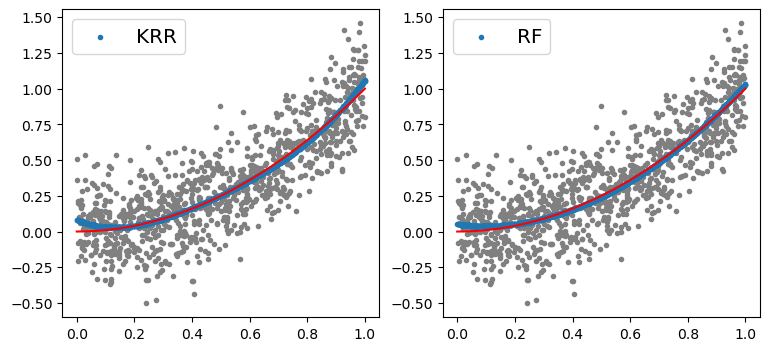

In [ ]:
fig,ax=plt.subplots(1,2, figsize=(9, 4))
plot_x=np.linspace(0,1,1000)
ax[0].scatter(calibration_x,calibration_y,marker=".",color='gray',label='_nolegend_')
ax[0].scatter(data.T[0],krr_pred,marker=".")
ax[0].plot(plot_x,plot_x**2,color="red")
ax[0].legend(["KRR"],fontsize="x-large")
ax[1].scatter(calibration_x,calibration_y,marker=".",color='gray',label='_nolegend_')
ax[1].scatter(data.T[0],rf_pred,marker=".")
ax[1].plot(plot_x,plot_x**2,color="red")
ax[1].legend(["RF"],fontsize="x-large")
plt.show()

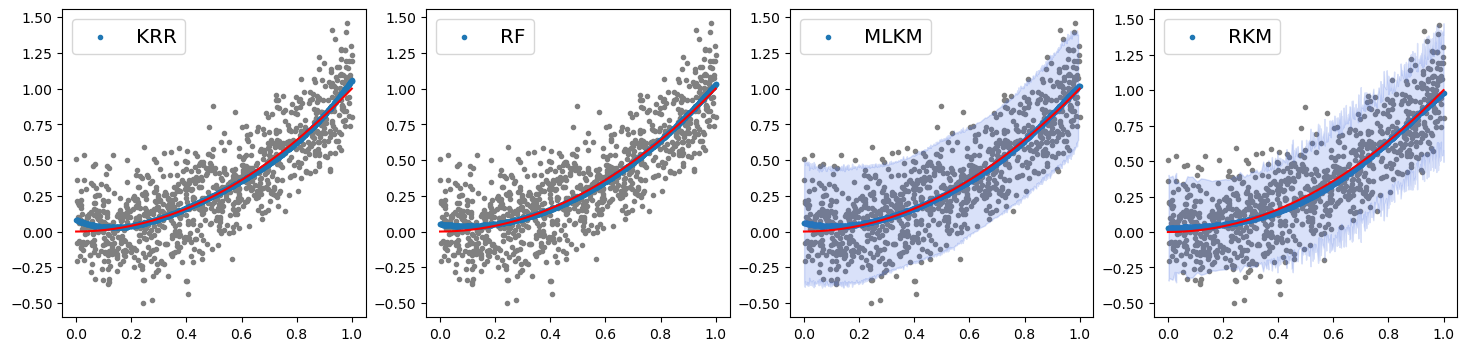

In [ ]:
fig,ax=plt.subplots(1,4, figsize=(18, 4))
plot_x=np.linspace(0,1,1000)
ax[0].scatter(calibration_x,calibration_y,marker=".",color='gray',label='_nolegend_')
ax[0].scatter(data.T[0],krr_pred,marker=".")
ax[0].plot(plot_x,plot_x**2,color="red")
ax[0].legend(["KRR"],fontsize="x-large")
ax[1].scatter(calibration_x,calibration_y,marker=".",color='gray',label='_nolegend_')
ax[1].scatter(data.T[0],rf_pred,marker=".")
ax[1].plot(plot_x,plot_x**2,color="red")
ax[1].legend(["RF"],fontsize="x-large")
ax[2].scatter(calibration_x,calibration_y,marker=".",color='gray',label='_nolegend_')
ax[2].scatter(data.T[0],kernel_pred,marker=".")
ax[2].plot(plot_x,plot_x**2,color="red")
ax[2].legend(["MLKM"],fontsize="x-large")
band=np.array([pred_xall,list(map(lambda x,y:x-y, pred_yall,dist)),list(map(lambda x,y:x+y, pred_yall,dist))]).T
sort_band=band[np.argsort(band[:,0])]
plot_x=np.linspace(0,1,1000)
ax[2].fill_between(sort_band.T[0],sort_band.T[1],sort_band.T[2],alpha=0.2,color='royalblue')
ax[3].scatter(calibration_x,calibration_y,marker=".",color='gray',label='_nolegend_')
ax[3].scatter(data.T[0],rk_pred,marker=".")
ax[3].plot(plot_x,plot_x**2,color="red")
ax[3].legend(["RKM"],fontsize="x-large")
band=np.array([pred_xall2,list(map(lambda x,y:x-y, pred_yall2,dist2)),list(map(lambda x,y:x+y, pred_yall2,dist2))]).T
sort_band=band[np.argsort(band[:,0])]
plot_x=np.linspace(0,1,1000)
ax[3].fill_between(sort_band.T[0],sort_band.T[1],sort_band.T[2],alpha=0.2,color='royalblue')
plt.show()

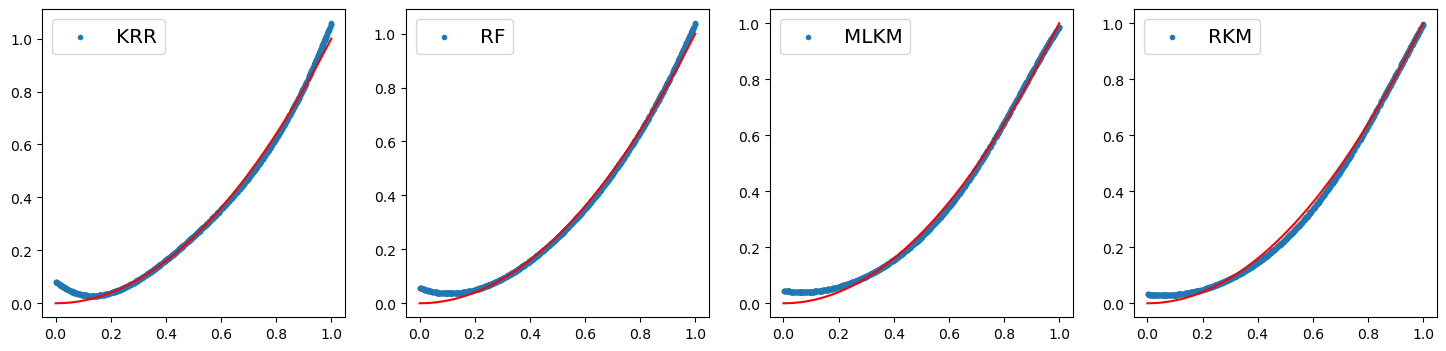

In [ ]:
fig,ax=plt.subplots(1,4, figsize=(18, 4))
plot_x=np.linspace(0,1,1000)
ax[0].scatter(data.T[0],krr_pred,marker=".")
ax[0].plot(plot_x,plot_x**2,color="red")
ax[0].legend(["KRR"],fontsize="x-large")
ax[1].scatter(data.T[0],rf_pred,marker=".")
ax[1].plot(plot_x,plot_x**2,color="red")
ax[1].legend(["RF"],fontsize="x-large")
ax[2].scatter(data.T[0],kernel_pred,marker=".")
ax[2].plot(plot_x,plot_x**2,color="red")
ax[2].legend(["MLKM"],fontsize="x-large")
ax[3].scatter(data.T[0],rk_pred,marker=".")
ax[3].plot(plot_x,plot_x**2,color="red")
ax[3].legend(["RKM"],fontsize="x-large")
plt.show()